In [352]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
import os
sns.set(style = "darkgrid")
%matplotlib inline

In [353]:
dataset_path = os.getcwd() + '/abalone/Dataset.data'
attributes = ['sex', 'length', 'diam', 'height', 'whole_weight', 
              'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']

In [354]:
data = pd.read_csv(dataset_path, delim_whitespace=True, header=None, names=attributes)

In [355]:
data = pd.concat([pd.get_dummies(data['sex'], prefix='sex'), data], axis=1)
data.drop(columns=['sex'], inplace=True)
data.head()

,sex_F,sex_I,sex_M,length,diam,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,0,0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0,0,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1,0,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0,0,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0,1,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [356]:
data = data.sample(frac=1, axis=0, random_state=1)
data.reset_index(drop=True, inplace=True)
data.head()

,sex_F,sex_I,sex_M,length,diam,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,1,0,0,0.440,0.340,0.100,0.4510,0.1880,0.0870,0.130,10
1,0,0,1,0.565,0.435,0.150,0.9900,0.5795,0.1825,0.206,8
2,0,0,1,0.370,0.280,0.105,0.2340,0.0905,0.0585,0.075,9
3,0,0,1,0.580,0.455,0.135,0.7955,0.4050,0.1670,0.204,10
4,1,0,0,0.525,0.390,0.135,0.6005,0.2265,0.1310,0.210,16


In [357]:
def gradient_descent(X, y, coeff, eta, niter): # theta_i
    """
        eta: step size
        X: training set
        y: given predicted values for X
        return: coeff
    """
    n_iteration = 0
    
    while n_iteration < niter:
        h_theta = predict(X, coeff) - y
        gradient = np.zeros(coeff.shape[0]) # theta_0 included
        
        for i in range(0, coeff.shape[0]): # theta_i
            gradient[i] = np.sum(np.dot(h_theta, X[:, i]))
        
#         print(gradient)
        coeff = coeff - (2/X.shape[0])*eta*gradient
        
#         print('Iteration', n_iteration,' : ', loss(X, y, coeff)) # RMSE
        n_iteration = n_iteration + 1
    
    return coeff

In [358]:
def gradient_descent_l1(X, y, coeff, eta, alpha, niter): # theta_i
    """
        eta: step size
        X: training set
        y: given predicted values for X
        return: coeff
    """
    n_iteration = 0
    
    while n_iteration < niter:
        h_theta = predict(X, coeff) - y
        gradient = np.zeros(coeff.shape[0]) # theta_0 included
        
        for i in range(0, coeff.shape[0]): # theta_i
            gradient[i] = np.sum(np.dot(h_theta, X[:, i])) + alpha*np.sign(coeff[i])
        
#         print(gradient)
        coeff = coeff - (2/X.shape[0])*eta*gradient
        
#         print('Iteration', n_iteration,' : ', loss(X, y, coeff)) # RMSE
        n_iteration = n_iteration + 1
    
    return coeff

In [359]:
def gradient_descent_l2(X, y, coeff, eta, alpha, niter): # theta_i
    """
        eta: step size
        X: training set
        y: given predicted values for X
        return: coeff
    """
    n_iteration = 0
    
    while n_iteration < niter:
        h_theta = predict(X, coeff) - y
        gradient = np.zeros(coeff.shape[0]) # theta_0 included
        
        for i in range(0, coeff.shape[0]): # theta_i
            gradient[i] = np.sum(np.dot(h_theta, X[:, i])) + 2*alpha*coeff[i] 
        
#         print(gradient)
        coeff = coeff - (2/X.shape[0])*eta*gradient
        
#         print('Iteration', n_iteration,' : ', loss(X, y, coeff)) # RMSE
        n_iteration = n_iteration + 1
    
    return coeff

In [360]:
def zscore_normalization(X, nu, std):
    """
        X: data 2d array
        nu: 1d mean vector
        std: 1d std vector
    """
    X = (X - nu)/std
    return X

In [361]:
def loss(X, y, coeff): # J_theta is loss function : rmse
    """
        X: training set 2-d array
        y: given predicted values for X 1-d array
        return : root mean squared error
    """
    h_theta = predict(X, coeff) - y
    jtheta = (1/X.shape[0])*np.sum(np.power(h_theta, 2))
    return np.sqrt(jtheta) # RMSE = sqrt(Mean(residual^2))

In [362]:
def loss_l1(X, y, coeff, alpha): # loss function : logistic loss
    """
        X: training set 2-d array
        y: given predicted values for X 1-d array
        return : total loss
    """
    h_theta = predict(X, coeff) - y
    jtheta = (1/X.shape[0])*np.sum(np.power(h_theta, 2))
    return np.sqrt(jtheta) + alpha*np.sum(np.abs(coeff)) # RMSE = sqrt(Mean(residual^2)) + Regularization loss

In [363]:
def loss_l2(X, y, coeff, alpha): # loss function : logistic loss
    """
        X: training set 2-d array
        y: given predicted values for X 1-d array
        return : total loss
    """
    h_theta = predict(X, coeff) - y
    jtheta = (1/X.shape[0])*np.sum(np.power(h_theta, 2))
    return np.sqrt(jtheta) + alpha*np.sum(np.power(coeff, 2))

In [364]:
def predict(X, coeff): # H_theta(x) 
    """
        x: Data point 1-d array
        coeff: 1-d array
        returns: prediction for all data points 1-d array
    """
    return np.dot(X, coeff)

In [365]:
def plot_error(result, alpha): # Plot alpha vs erro for both training and validation data
    matplotlib.rc('figure', figsize=(8, 5))
    ax = sns.lineplot(x='param_alpha', y='mean_train_score', data=result, label='mean_train_score', color='b')
    sns.lineplot(x='param_alpha', y='mean_test_score', data=result, color='r', label='mean_test_score', ax=ax)
    ax.set_title('Error vs alpha')
    ax.legend()
    ax.set_ylabel('Error')
    plt.axvline(alpha, 0, 1, linestyle='--')
    plt.show()
    return

### Regularization
>From the previous part, identify the validation set that has the lowest RMSE, and
hold it out as the test set. Use the remaining 80% of the data as the new training +
validation set. Note that your model should never see the test set (neither
for training, nor for validation).

In [366]:
def kfold(X, k, eta, niter):
    """
    X: 2d numpy array with y
    k: no. of splits of X    
    
    returns: loss_kcv = 2d array (normal eq solution)
             avgrmse for training  & validation
    """
    
    n = X.shape[1] # LR Coefficients
    fold = np.array_split(X, k)
    
    fold_rmse = np.inf # current fold validation rmse 
    X_test_new = 0
    y_test_new = 0
    X_train_plus_vad = 0
    y_train_plus_vad = 0    
    
    for i in range(0, k): # ith fold is for validation 
        coeff = np.zeros(n)
        vald = fold[i]
        pos = list(range(0, k))
        pos.remove(i)
        
        train_folds = [fold[j] for j in pos]
        train_set = np.vstack(tuple(train_folds))
#         print(train_set.shape, vald.shape)
        
        y_train = train_set[:, -1]    # actual y values
        X_train = train_set[:, :-1]
        y_test = vald[:, -1]     
        X_test = vald[:, :-1]
        
        # normalization using zscore before adding offset
        current_mean = np.mean(X_train, axis=0)
        current_std = np.std(X_train, axis=0)
        X_train = zscore_normalization(X_train, current_mean, current_std)
        X_test = zscore_normalization(X_test, current_mean, current_std)  # using same mean, std of training set
        
        # bias = 1 in the training set and validation set - 1*theta_0
        X_train = np.hstack((np.ones(X_train.shape[0])[:, np.newaxis], X_train))
        X_test = np.hstack((np.ones(X_test.shape[0])[:, np.newaxis], X_test))
        
        # train on current training set
        theta = gradient_descent(X_train, y_train, coeff, eta, niter)
        
        # test on current validation set
        test_rmse = loss(X_test, y_test, theta)
        print(test_rmse)
        if(test_rmse < fold_rmse):
            fold_rmse = test_rmse
            X_test_new = vald[:, :-1]
            y_test_new = vald[:, -1] 
            X_train_plus_vad = train_set[:, :-1] 
            y_train_plus_vad =  train_set[:, -1] 
            
    return X_train_plus_vad, y_train_plus_vad, X_test_new, y_test
    

In [367]:
eta = 0.14  # at 0.15 error blows up
niter = 250
X_train, y_train, X_test, y_test = kfold(data.to_numpy(), 5, eta, niter) #  new train+plus_Vald and test set

2.206640210386414
2.3606164470496185
2.2271400533296535
2.286804449240762
2.1022723488423365


In [368]:
# Normalize 
current_mean = np.mean(X_train, axis=0)
current_std = np.std(X_train, axis=0)
X_train = zscore_normalization(X_train, current_mean, current_std)
X_test = zscore_normalization(X_test, current_mean, current_std)  # using same mean, std of training set

In [369]:
# Add bias = 1 
X_train = np.hstack((np.ones(X_train.shape[0])[:, np.newaxis], X_train))
X_test = np.hstack((np.ones(X_test.shape[0])[:, np.newaxis], X_test))

### Ridge regression

In [370]:
# design score function
def rmse_func(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

rmse_scorer = make_scorer(rmse_func, greater_is_better=False)

In [371]:
def regularization_result(clf):
    z = pd.DataFrame(clf.cv_results_)
    z[['mean_train_score', 'mean_test_score']] = -1*z[['mean_train_score', 'mean_test_score']] 
    return z[[ 'param_alpha', 'mean_train_score', 'mean_test_score']]
    

In [376]:
params = {
    'alpha':[0.0001, 0.001, 0.1, 0.2, 1, 1.5, 2, 2.25, 2.4, 2.5, 3, 4, 5, 6, 7] # l2 regularization strength
}
ridge = Ridge(random_state=1, fit_intercept=True)
clf = GridSearchCV(ridge, params, scoring=rmse_scorer,
                   n_jobs=-1, cv=5, return_train_score=True)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=1,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.1, 0.2, 1, 1.5, 2, 2.25,
                                   2.4, 2.5, 3, 4, 5, 6, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(rmse_func, greater_is_better=False),
             verbose=0)

In [377]:
regularization_df = regularization_result(clf) # this test_score is not the Actual test data score.
regularization_df

,param_alpha,mean_train_score,mean_test_score
0,0.0001,2.215828,2.250817
1,0.001,2.215828,2.250816
2,0.1,2.215829,2.250761
3,0.2,2.215833,2.250709
4,1,2.215951,2.250403
5,1.5,2.216090,2.250300
6,2,2.216272,2.250252
7,2.25,2.216376,2.250247
8,2.4,2.216443,2.250249
9,2.5,2.216489,2.250253


Test rmse score:  2.2502470797888114
Optimal L2 parameter:  {'alpha': 2.25}


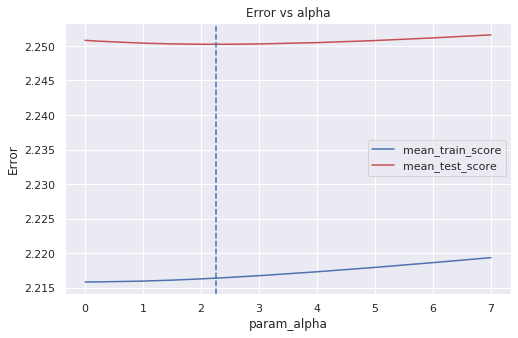

In [378]:
print('Test rmse score: ', np.abs(clf.best_score_))
print('Optimal L2 parameter: ', clf.best_params_)
plot_error(regularization_df, clf.best_params_['alpha'])

### Lasso 

In [379]:
params = {
    'alpha':[0.0001, 0.001, 0.0015, 0.002, 0.004, 0.008] # l1 regularization strength
}
lasso = Lasso(random_state=1, fit_intercept=True)
clf2 = GridSearchCV(lasso, params, scoring=rmse_scorer,
                   n_jobs=-1, cv=5, return_train_score=True)
clf2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=1,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.0015, 0.002, 0.004, 0.008]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(rmse_func, greater_is_better=False),
             verbose=0)

In [380]:
regularization_df2 = regularization_result(clf2) # this test_score is not the Actual test data score.
regularization_df2

,param_alpha,mean_train_score,mean_test_score
0,0.0001,2.215828,2.250770
1,0.001,2.215884,2.250373
2,0.0015,2.215954,2.250194
3,0.002,2.216053,2.250042
4,0.004,2.216657,2.250084
5,0.008,2.219052,2.251417


Test rmse score:  2.2500423284869013
Optimal L1 parameter:  {'alpha': 0.002}


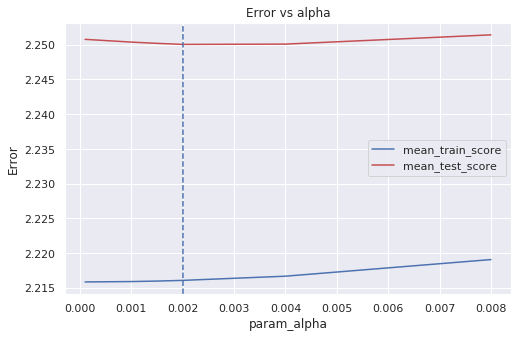

In [381]:
print('Test rmse score: ', np.abs(clf2.best_score_))
print('Optimal L1 parameter: ', clf2.best_params_)
plot_error(regularization_df2, clf2.best_params_['alpha'])

In [382]:
print('Coefficient of best estimator Lasso :', clf2.best_estimator_.coef_)

Coefficient of best estimator Lasso : [ 0.          0.00511671 -0.37338153 -0.          0.05394752  1.07921171
  0.42836072  4.08521016 -4.19114038 -1.12899578  1.27626829]


## Optimal value of alpha for L1 and L2 is 0.002 and 2.25

In [383]:
## Using these values of l1 and l2 with modified gradient descent.

def modifiedGradientDescent(eta, alpha1, alpha2,  niter):
    """
    X: 2d numpy array with y
    k: no. of splits of X    
    
    returns: loss_kcv = 2d array (normal eq solution)
             avgrmse for training  & validation
    """
    global X_train, X_test, y_train, y_test
    n = X_train.shape[1] # LR Coefficients
    coeff = np.zeros(n)
    
    rmse_l1 = np.zeros((niter)) # training 1st col,  validation 2nd col
    rmse_l2 = np.zeros((niter)) # training 1st col,  validation 2nd col
    
    for j in range(0, niter):
        # train on current training set
        theta_l1 = gradient_descent_l1(X_train, y_train, coeff, eta, alpha1, j)
        rmse_l1[j] = np.array([loss(X_train, y_train, theta_l1)])
            
        theta_l2 = gradient_descent_l2(X_train, y_train, coeff, eta, alpha2, j)
        rmse_l2[j] = np.array([loss(X_train, y_train, theta_l2)])
    
    theta2 = gradient_descent_l2(X_train, y_train, coeff, eta, alpha2, niter)
    print('RMSE on test set using L2 : ', loss(X_test, y_test, theta2))
   
    theta1 = gradient_descent_l2(X_train, y_train, coeff, eta, alpha1, niter)
    print('RMSE on test set using L1 : ', loss(X_test, y_test, theta1))
    return rmse_l1, rmse_l2

In [384]:
eta = 0.14  # above 0.15 loss blows up at 250 iter
niter = 250
alpha1 = 0.002
alpha2 = 2.25
gradient_rmse_l1, gradient_rmse_l2 = modifiedGradientDescent(eta, alpha1, alpha2, niter)

RMSE on test set using L2 :  2.103649280153166
RMSE on test set using L1 :  2.102273511885876


In [385]:
seperate_training_l1 = np.hstack((np.arange(niter)[:, np.newaxis]+1, gradient_rmse_l1[:, np.newaxis]))
training_rmse_l1 = pd.DataFrame(seperate_training_l1, columns=['iteration_number', 'rmse'])

In [386]:
seperate_training_l2 = np.hstack((np.arange(niter)[:, np.newaxis]+1, gradient_rmse_l2[:, np.newaxis]))
training_rmse_l2 = pd.DataFrame(seperate_training_l2, columns=['iteration_number', 'rmse'])

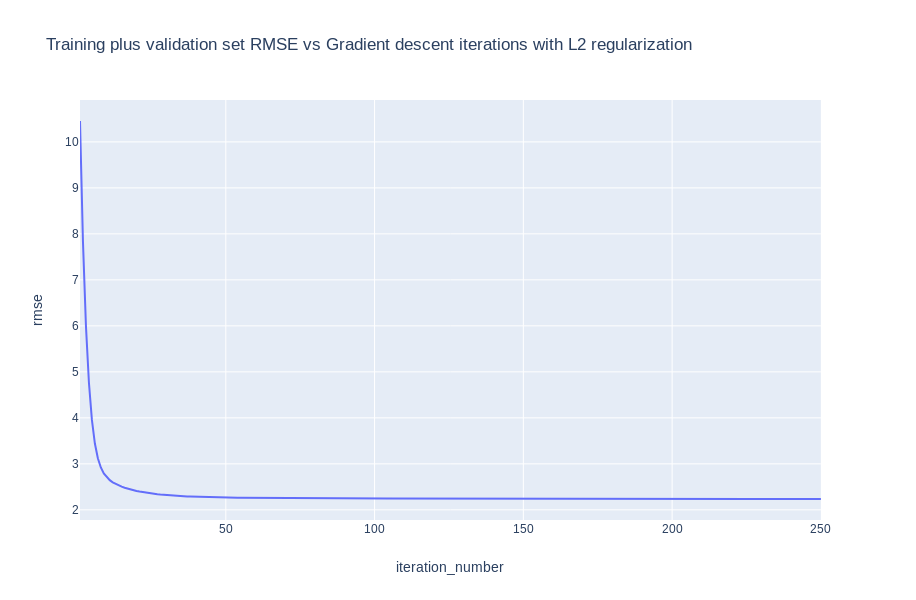

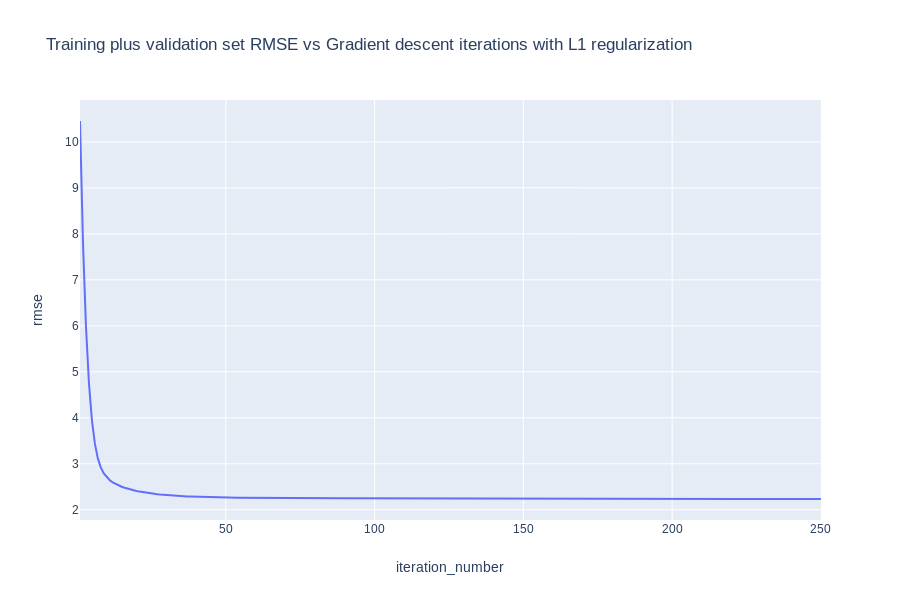

In [388]:
fig = px.line(training_rmse_l2, x='iteration_number', y='rmse', hover_name='rmse', 
              hover_data=['rmse', 'iteration_number'],
              title='Training plus validation set RMSE vs Gradient descent iterations with L2 regularization')

fig.show()

fig = px.line(training_rmse_l1, x='iteration_number', y='rmse', hover_name='rmse', 
              hover_data=['rmse', 'iteration_number'],
              title='Training plus validation set RMSE vs Gradient descent iterations with L1 regularization')
fig.show()

In [389]:
print('L2 Training RMSE :',gradient_rmse_l2[-1]) # last row elements
print('L1 Validation RMSE :', gradient_rmse_l1[-1])

L2 Training RMSE : 2.2356950074618633
L1 Validation RMSE : 2.234792969735529
